- Threshold policy: As we change threshold, look at p
- w-Lookahead policy: As we change w, look at p

We compare the average queue length of the two models as p changes.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

# Define customer for the threshold policy
Customer = namedtuple("Customer", "arrival_time")
def customer(arrival_time=-1):
    return Customer(arrival_time=arrival_time)

# Define customer for the w-lookahead policy
# mu1 is the slow service rate and mu2 is the fast service rate
WCustomer = namedtuple("WCustomer", "arrival_time slow_service_time fast_service_time enter_service_time service_time arrival_index fast")
def wcustomer(arrival_time=-1, mu1=-1, mu2=-1, arrival_index=0):
    slow = exp(mu1)
    fast = slow * mu1/mu2
    return WCustomer(arrival_time=arrival_time, slow_service_time=slow,
                     fast_service_time=fast, enter_service_time=-1,
                     service_time=-1, arrival_index=arrival_index, fast=False)

def wcustomer_with_parameters(w, current_time, fast):
    if fast:
        return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                         fast_service_time=w.fast_service_time, enter_service_time=current_time,
                         service_time=current_time+w.fast_service_time,
                         arrival_index=w.arrival_index, fast=True)
    return WCustomer(arrival_time=w.arrival_time, slow_service_time=w.slow_service_time,
                     fast_service_time=w.fast_service_time, enter_service_time=current_time,
                     service_time=current_time+w.slow_service_time,
                     arrival_index=w.arrival_index, fast=False)

In [3]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# surge_threshold = the queue length to activate surge at
# c = number of servers (1)
# N0 = starting number in the queue
# Tmax = time horizon

def MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    end_measuring_surge = 0
    
    # customers currently being served by a server
    servers = [customer(0) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(0) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        event_rate = lambd + mu1*(0 < N[-1] and N[-1] < surge_threshold) + mu2*(surge_threshold <= N[-1])
        next_event = exp(event_rate)
        T.append(t_temp + next_event)
        event = rand()
            
        ##### ARRIVAL ##### 
        if event < lambd / event_rate:
            N.append(N[-1] + 1) 
            if len(servers) < c:
                servers.append(customer(T[-1]))
            else:
                queue.append(customer(T[-1]))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(customer(next_to_enter.arrival_time))
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000 and T[-1] < 9000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta
        if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]

    S = S / (end_measuring_surge - start_measuring_surge)
    in_surge = in_surge / (end_measuring_surge - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

In [4]:
# Example 2: M/M/1 queue starting as empty
# lambd = arrival rate
# mu1 = pre-surge service rate
# mu2 = post-surge service rate
# c = number of servers (1)
# w = the amount of time to look ahead
# Tmax = time horizon

# Heuristic:  upon beginning of service, look w-ahead. if the # departures in
# that time < # arrivals at the slow service rate, use the fast service rate.
# otherwise, use the slow service rate

# Constant arrival and departure rates for testing whether this works

def MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax):
    T             = [0]  # list of times that events occur in real time
    T_advance     = [0]  # list of events that get generated in advance
    t_temp        = 0    # temporary time to calculate delta
    N             = [0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    end_measuring_surge = 0
    p_wait_num = 0
    p_wait_denom = 0
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # generate arrivals independent of whether or not we speed up the customers
    arrivals = []
    while T_advance[-1] < Tmax:
        t_temp = T_advance[-1]
        next_arrival = t_temp + exp(lambd)
        T_advance.append(next_arrival)
        arrivals.append(wcustomer(next_arrival, mu1, mu2, len(T_advance) - 2))
    #print(arrivals)
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1]+1) 
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                for i in range(arrival_index, len(arrivals) - 1):
                    if arrivals[i].arrival_time > w_lookahead:
                        break
                    else:
                        num_arrivals += 1
                for i in range(arrival.arrival_index - 1, len(arrivals) - 1):
                    cumulative_service_time += arrivals[i].slow_service_time
                    if cumulative_service_time > w_lookahead:
                        break
                    else:
                        num_departures += 1
                if num_departures >= num_arrivals: # use the slow service rate   
                    servers.append(wcustomer_with_parameters(arrival, T[-1], False))
                    #print("Look ahead at time %.3f has Departures %d Arrivals %d -> use SLOW" % (T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(arrival, T[-1], True))
                    #print("Look ahead at time %.3f has Departures %d Arrivals %d -> use FAST" % (T[-1], num_departures, num_arrivals))
        
            else:
                queue.append(arrival)
                p_wait_num += 1
            p_wait_denom+=1
            #print("ARRIVAL %.3f departure %.3f abandonment %.3f" % (next_arrival, next_departure, next_abandonment))
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1]-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
                ##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                # w-lookahead: decide whether to use fast or slow service rate
                cumulative_service_time = T[-1]
                w_lookahead = T[-1] + w
                num_arrivals = 0
                num_departures = 0
                for i in range(arrival_index, len(arrivals) - 1):
                    if arrivals[i].arrival_time > w_lookahead:
                        break
                    else:
                        num_arrivals += 1
                for i in range(arrival.arrival_index - 1, len(arrivals) - 1):
                    cumulative_service_time += arrivals[i].slow_service_time
                    if cumulative_service_time > w_lookahead:
                        break
                    else:
                        num_departures += 1
                if num_departures >= num_arrivals: # use the slow service rate   
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
                    #print("Look ahead at time %.3f has Departures %d Arrivals %d -> use SLOW" % (T[-1], num_departures, num_arrivals))
                else: # use the fast service rate
                    servers.append(wcustomer_with_parameters(next_to_enter, T[-1], True))
                    #print("Look ahead at time %.3f has Departures %d Arrivals %d -> use FAST" % (T[-1], num_departures, num_arrivals))
        
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
        #print("Next arrival %.3f Next departure %.3f" % (next_arrival, next_departure))
        

    S = S / (end_measuring_surge - start_measuring_surge)
    in_surge = in_surge / (end_measuring_surge - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

In [5]:
lambd = 1
mu1 = 0.5
mu2 = 2
c = 1
N0 = 0
Tmax = 10000


surge_threshold = 2
w = 100

In [6]:
w_lookahead_x = []
w_lookahead_y = []

ws = [1.5, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]

for w in ws:
    s = """\n%.2f Time lookahead.""" % (w)
    print(s)
    start = time.time()
    T, N, W, S, in_surge = MM1WithWLookaheadConstant(lambd, mu1, mu2, c, w, Tmax)
    end = time.time()
    #figure(figsize=(15,6))
    #plot(T[:int(len(T)*0.9)], N[:int(len(T)*0.9)])
    #xlabel('Time')
    #ylabel('Number of clients')
    #title('Number of clients in the M/[slow M+fast M]/C queue %.2f/%.2f+%.2f/%d, with %.2f-time lookahead'
    #      % (lambd, mu1, mu2, c, w))

    print("Average queue length %.3f"%(S))
    print("P in surge %.3f"%(in_surge))
    print("Computed in %.3f seconds" % (end-start))
    w_lookahead_x.append(in_surge)
    w_lookahead_y.append(S)


1.50 Time lookahead.
Average queue length 34.350
P in surge 0.347
Computed in 0.606 seconds

2.00 Time lookahead.
Average queue length 7.798
P in surge 0.361
Computed in 0.586 seconds

3.00 Time lookahead.
Average queue length 3.884
P in surge 0.412
Computed in 0.588 seconds

4.00 Time lookahead.
Average queue length 2.218
P in surge 0.429
Computed in 0.582 seconds

5.00 Time lookahead.
Average queue length 1.958
P in surge 0.449
Computed in 0.618 seconds

10.00 Time lookahead.
Average queue length 1.797
P in surge 0.475
Computed in 0.520 seconds

20.00 Time lookahead.
Average queue length 1.468
P in surge 0.498
Computed in 0.580 seconds

50.00 Time lookahead.
Average queue length 1.360
P in surge 0.516
Computed in 0.739 seconds

100.00 Time lookahead.
Average queue length 1.233
P in surge 0.497
Computed in 0.890 seconds

200.00 Time lookahead.
Average queue length 1.300
P in surge 0.520
Computed in 1.310 seconds

500.00 Time lookahead.
Average queue length 1.202
P in surge 0.499
Comp

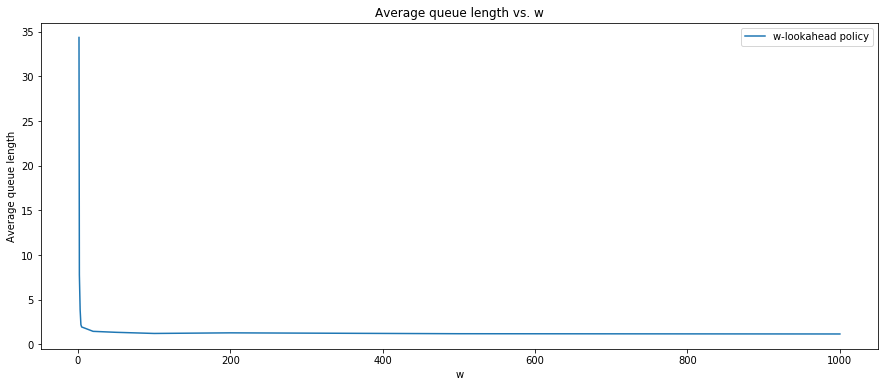

In [7]:
figure(figsize=(15,6))
title('Average queue length vs. w')
xlabel('w')
ylabel('Average queue length')
plot(ws, w_lookahead_y, label="w-lookahead policy")
legend()
plt.show()

In [8]:
threshold_x = []
threshold_y = []

thresholds = range(1, 15)

for surge_threshold in thresholds:
    s = """\n%d surge threshold.""" % (surge_threshold)
    print(s)
    start = time.time()
    T, N, W, S, in_surge = MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax)
    end = time.time()
    #figure(figsize=(15,6))
    #plot(T, N)
    #xlabel('Time')
    #ylabel('Number of clients')
    #title('Number of clients in the M/M/C queue %.2f/%.2f/%d, with surge to %.2f at threshold %d'
    #      % (lambd, mu1, c, mu2, surge_threshold))
    
    print("Average queue length %.3f"%(S))
    print("P in surge %.3f"%(in_surge))
    print("Computed in %.3f seconds" % (end-start))
    threshold_x.append(in_surge)
    threshold_y.append(S)


1 surge threshold.
Average queue length 0.967
P in surge 0.490
Computed in 0.493 seconds

2 surge threshold.
Average queue length 1.630
P in surge 0.405
Computed in 0.600 seconds

3 surge threshold.
Average queue length 2.317
P in surge 0.354
Computed in 0.590 seconds

4 surge threshold.
Average queue length 3.270
P in surge 0.357
Computed in 0.588 seconds

5 surge threshold.
Average queue length 4.122
P in surge 0.334
Computed in 0.592 seconds

6 surge threshold.
Average queue length 5.060
P in surge 0.335
Computed in 0.553 seconds

7 surge threshold.
Average queue length 6.115
P in surge 0.348
Computed in 0.558 seconds

8 surge threshold.
Average queue length 7.041
P in surge 0.332
Computed in 0.544 seconds

9 surge threshold.
Average queue length 7.939
P in surge 0.323
Computed in 0.520 seconds

10 surge threshold.
Average queue length 9.032
P in surge 0.343
Computed in 0.655 seconds

11 surge threshold.
Average queue length 9.972
P in surge 0.316
Computed in 0.588 seconds

12 surg

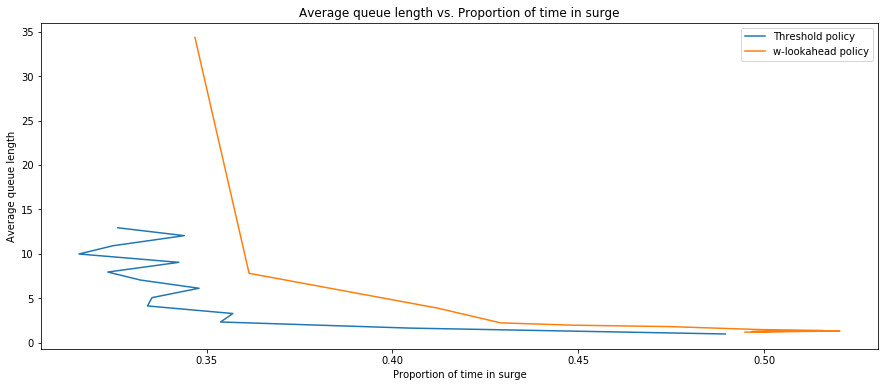

In [9]:
figure(figsize=(15,6))
title('Average queue length vs. Proportion of time in surge')
xlabel('Proportion of time in surge')
ylabel('Average queue length')
plot(threshold_x, threshold_y, label="Threshold policy")
plot(w_lookahead_x, w_lookahead_y, label="w-lookahead policy")
legend()
plt.show()